---
Import image
---

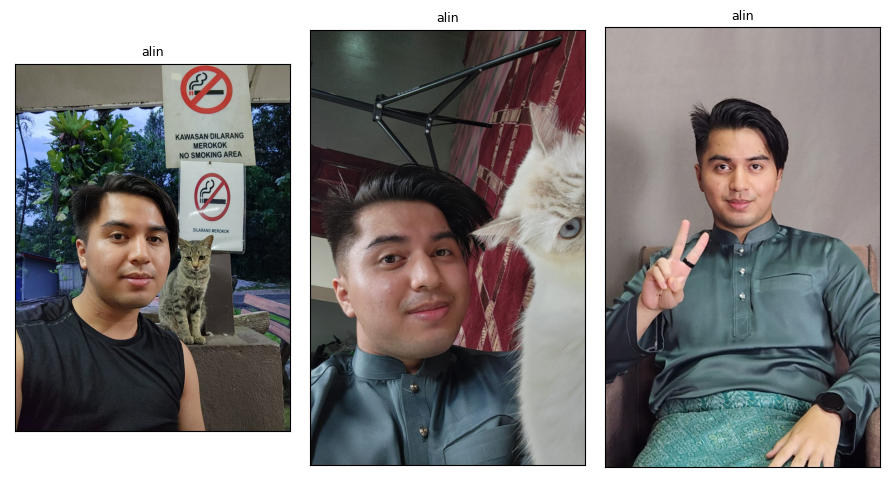

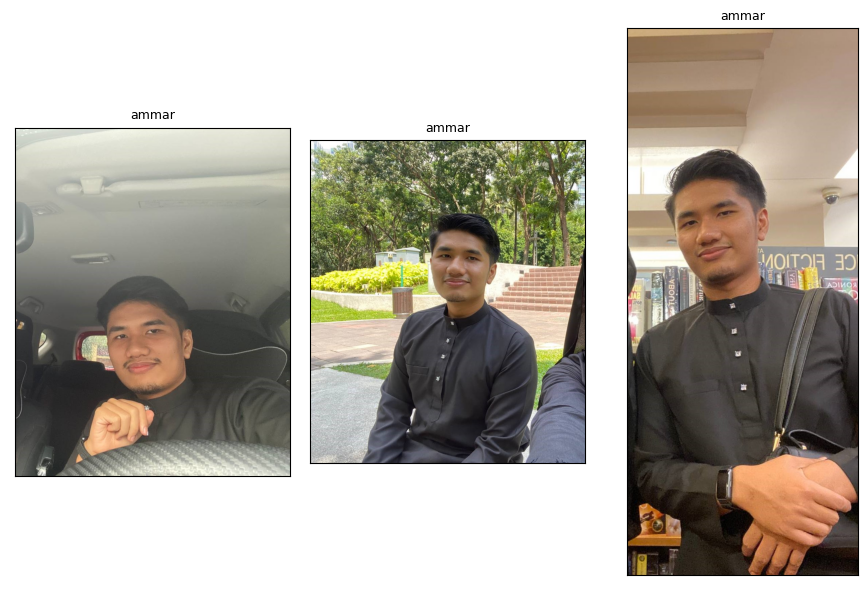

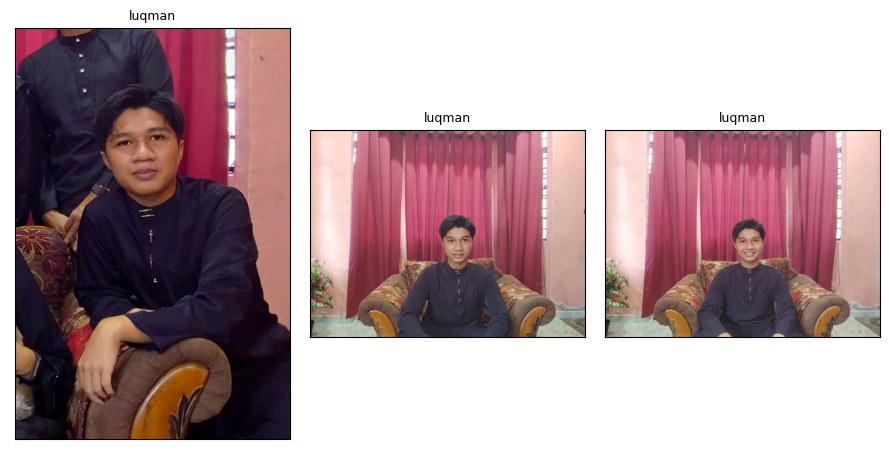

In [7]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from lib.person import Person

img_paths = [x[0] for x in os.walk("./image/person")]
img_paths.pop(0)

persons = [Person(path, path.split('/')[-1].split('\\')[-1]) for path in img_paths]

for person in persons:
    for f in os.listdir(person.path):
        img = ImageOps.exif_transpose(Image.open(os.path.join(person.path,f)))
        person.img.append(img)

def print_person(persons, face_only = False):
    for person in persons:
        n = len(person.img)
        fig, ax = plt.subplots(nrows = 1, ncols = n, figsize=(n*3, n*2))
        for i, img in enumerate(person.img):
            if face_only:
                ax[i].imshow(person.img_face[i])
            else:
                ax[i].imshow(img)
            ax[i].set_title(person.name, fontsize=n*3)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
        plt.tight_layout()
        plt.show()

print_person(persons)

---
Face extraction with Haar Cascades Classifier
---
- https://www.datacamp.com/tutorial/face-detection-python-opencv

PyTorch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116
device: cuda


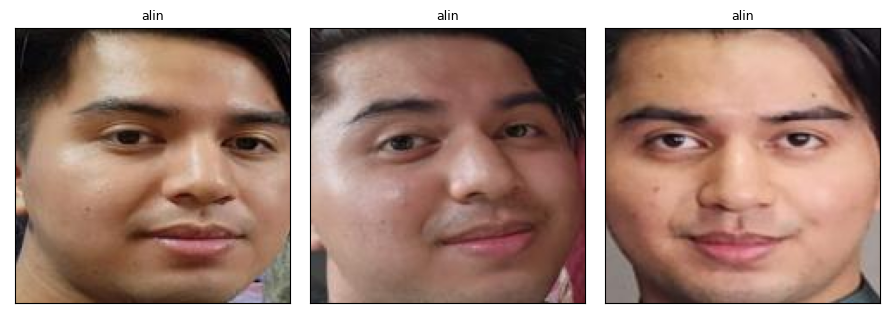

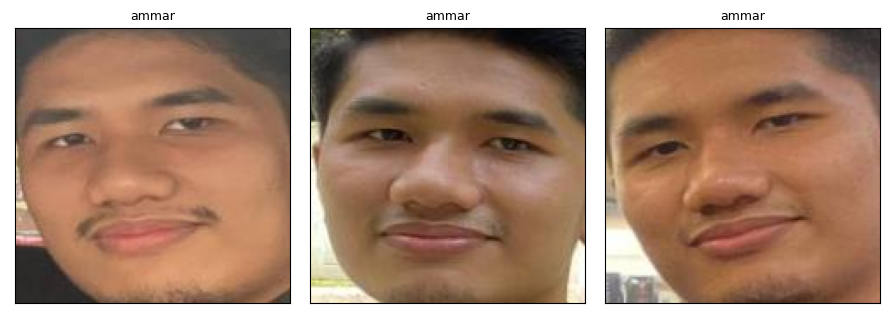

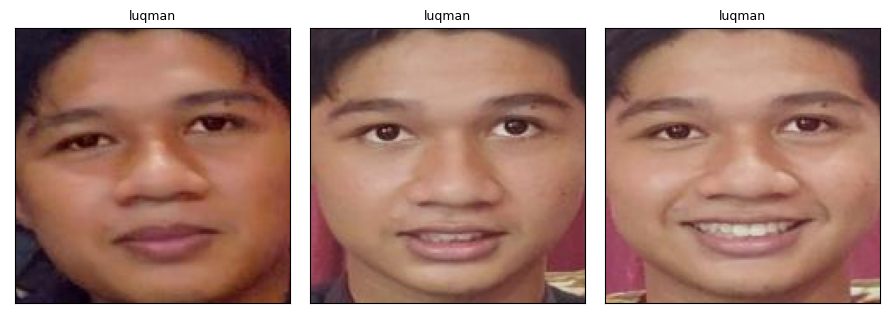

In [8]:
import torch
import torchvision
from facenet_pytorch import MTCNN

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"PyTorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"device: {DEVICE}")

mtcnn = MTCNN(
    device=DEVICE
)

for person in persons:
    person.img_tensor = []
    person.img_face = []
    for i, img in enumerate(person.img):
        path = f'./image/face/{person.name}//{i+1}.jpg'
        person.img_tensor.append(mtcnn(img, save_path=path))
        person.img_face.append(Image.open(path))

print_person(persons, face_only=True)

---
Create face embeddings with FaceNet
---
- https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

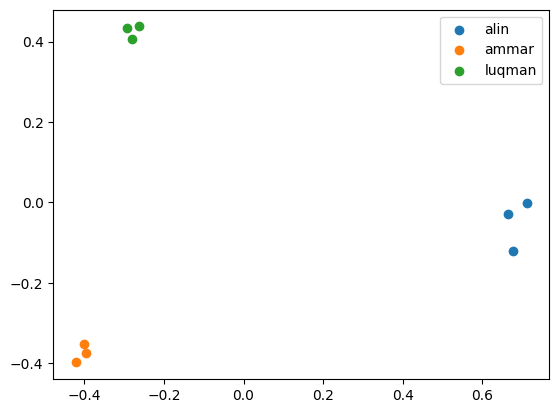

In [9]:
import torchvision.transforms as transforms
from facenet_pytorch import InceptionResnetV1
from sklearn.decomposition import PCA

resnet = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE)
pca = PCA(n_components=2)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

vector = torch.Tensor()
for person in persons:
    person.img_emb = []
    for img_tensor in person.img_tensor:
        emb = resnet(img_tensor.to(DEVICE).unsqueeze(0)).detach().cpu()
        person.img_emb.append(emb)
        vector = torch.cat((vector, emb), dim=0)

pca.fit(vector)
reduced_vectors = pca.transform(vector)
plot = []
label = []
for person in persons:
    person.pca_x = []
    person.pca_y = []
    for img in person.img:
        person.pca_x.append(reduced_vectors[0][0])
        person.pca_y.append(reduced_vectors[0][1])
        reduced_vectors = reduced_vectors[1:]
    plot.append(plt.scatter(person.pca_x, person.pca_y))
    label.append(person.name)
plt.legend(plot, label)
plt.show()

In [10]:
import pandas as pd

labels = []

for person in persons:
    for i, img in enumerate(person.img):
        labels.append(f'{person.name}')

dists = [[(e1 - e2).norm().item() for e2 in vector] for e1 in vector]
dists = pd.DataFrame(dists, columns=labels, index=labels)
display(dists)

,alin,alin,alin,ammar,ammar,ammar,luqman,luqman,luqman
alin,0.000000,0.621961,0.676061,1.254133,1.244342,1.256080,1.141114,1.168829,1.148163
alin,0.621961,0.000000,0.831836,1.262768,1.199950,1.228003,1.218785,1.200677,1.172980
alin,0.676061,0.831836,0.000000,1.193325,1.253097,1.289809,1.185894,1.169719,1.170190
ammar,1.254133,1.262768,1.193325,0.000000,0.500512,0.484628,0.876026,0.865902,0.896115
ammar,1.244342,1.199950,1.253097,0.500512,0.000000,0.454225,0.875797,0.874871,0.900241
ammar,1.256080,1.228003,1.289809,0.484628,0.454225,0.000000,0.914399,0.904809,0.896306
luqman,1.141114,1.218785,1.185894,0.876026,0.875797,0.914399,0.000000,0.444582,0.483578
luqman,1.168829,1.200677,1.169719,0.865902,0.874871,0.904809,0.444582,0.000000,0.268609
luqman,1.148163,1.172980,1.170190,0.896115,0.900241,0.896306,0.483578,0.268609,0.000000


---
SVM Classification Model
---

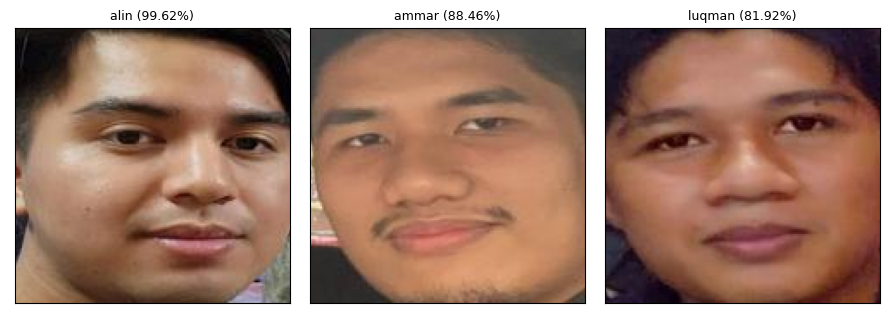

In [11]:
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

x = np.array(vector)
y = np.array(labels)

trainX = np.zeros((0,512))
testX = np.zeros((0,512))
trainY = np.zeros(0)
testY = np.zeros(0)

for person in persons:
    n = len(person.img)
    if n > 1:
        ys, y = y[:n], y[n:]
        testY, trainY = np.append(testY,ys[0]), np.append(trainY, ys[1:])
        xs, x = x[:n,:], x[n:,:]
        testX = np.append(testX, np.reshape(xs[0,:], (1,512)), axis=0)
        trainX = np.append(trainX, xs[1:,:], axis=0)
        
    else:
        trainX = vector
        trainY = labels

in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

out_encoder = LabelEncoder()
out_encoder.fit(trainY)
trainY = out_encoder.transform(trainY)
testY = out_encoder.transform(testY)

model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainY)

fig, ax = plt.subplots(nrows = 1, ncols = n, figsize=(n*3, n*2))
for i in range(len(testY)):
    sample = np.reshape(testX[i,:], (1,512))
    yhat_class = model.predict(sample)
    yhat_prob = model.predict_proba(sample)
    ypred = out_encoder.inverse_transform(yhat_class)
    yprob = np.max(yhat_prob*100)

    ax[i].imshow(persons[i].img_face[0])
    ax[i].set_title(f'{persons[i].name} ({round(yprob,2)}%)', fontsize=n*3)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

pickle.dump(model, open("./model/FaceNet-SVM.pkl", 'wb'))
pickle.dump(out_encoder, open("./model/encoder.pkl", 'wb'))